# Sentiment Analysis of IMDB Movie Reviews

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.  This is a dataset of 50,000 highly polar movie reviews for binary sentiment classification. We will train and test deep learning models and predict positive and negative reviews.  

## 1. Importing Libray

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
# Utility
import re
import os
# from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [51]:
# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [52]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2vec
import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gold\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# Disable GPU for LSTM model. Only use CPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [54]:
# tensorflow/keras
import tensorflow as tf
print("Tensorflow Version",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import keras 

from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras  import layers
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional, GRU
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Tensorflow Version 2.7.0
Num GPUs Available:  0


In [55]:
# SENTIMENT
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# Output
OUTPUT_PATH = 'Z:/kaggle/Sentiment AnalysisTWT/Output/'
KERAS_MODEL = OUTPUT_PATH + "model.h5"
TOKENIZER_MODEL = OUTPUT_PATH +"tokenizer.pkl"
ENCODER_MODEL = OUTPUT_PATH +"encoder.pkl"

## 2. Loading data

In [56]:
path = "Z:/Data/IMDB/IMDB Dataset.csv"
df = pd.read_csv(path, encoding = 'latin')
df.shape

(50000, 2)

In [57]:
df.head(5)

,text,target
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [58]:
# remove duplictes, 49582 unique record left
df = df.drop_duplicates()

In [59]:
df.describe()

,text,target
count,49582,49582
unique,49582,2
top,One of the other reviewers has mentioned that ...,positive
freq,1,24884


## 3. Visualizing the Data

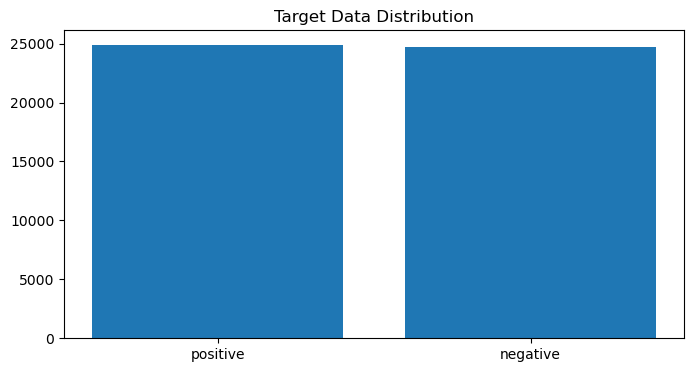

In [60]:
val_count = df.target.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Target Data Distribution")
plt.show()

# Positive Words

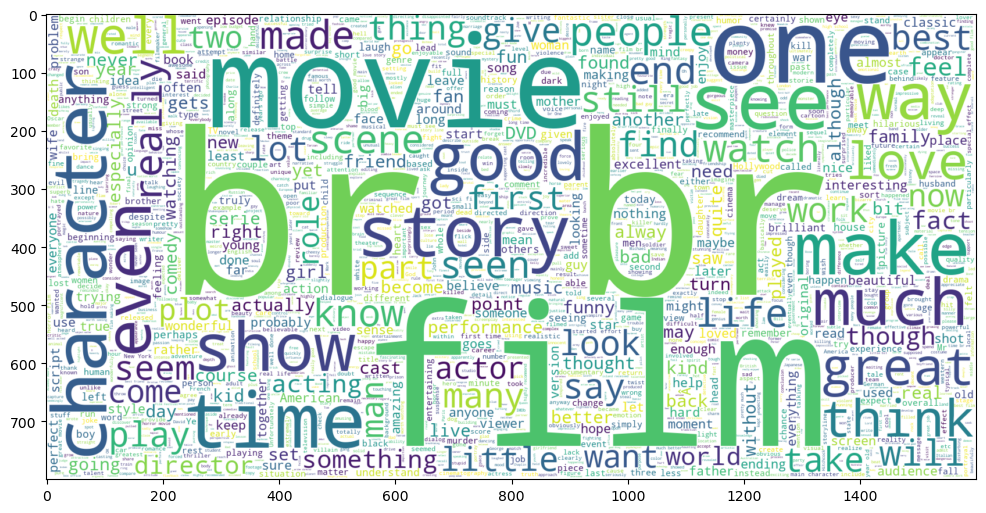

In [61]:
# Step 1: Read the data from the file and store it into ‘dataset’.
# Step 2: Create pixel array from the mask image.
# Step 3: Create the word cloud from the dataset. Set the background color, mask, and stop-words.
# Step 4: Store the final image into the disk.

from wordcloud import WordCloud

plt.figure(figsize = (12,12))

wc = WordCloud(background_color = 'white',
               max_words = 2000 , 
               width = 1600 , 
               height = 800).generate(" ".join(df[df.target == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

# Negtive Words

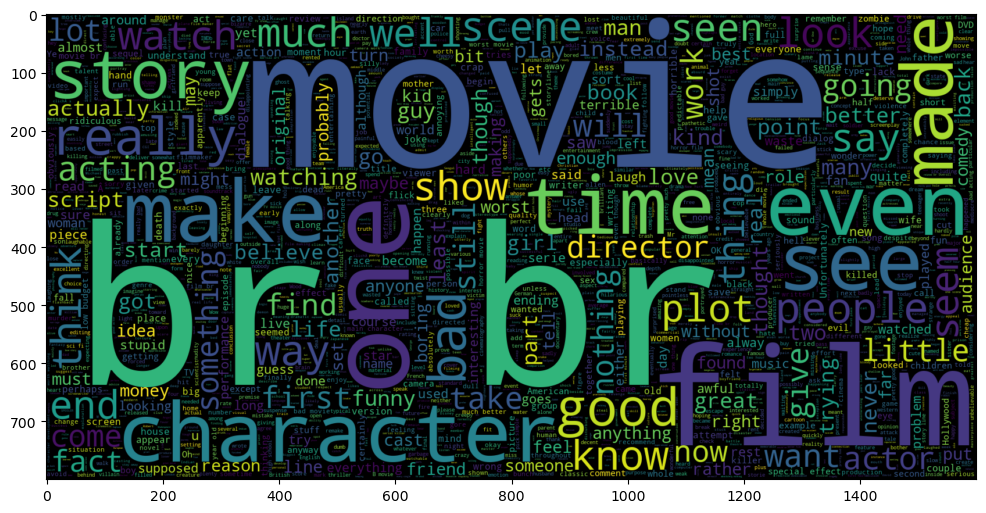

In [62]:
plt.figure(figsize = (12,12))

wc = WordCloud(background_color = 'black',
               max_words = 2000 , 
               width = 1600 , 
               height = 800).generate(" ".join(df[df.target == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.show()

## 4. Dataset Preprocessing

* 4.1 Removing URLs and User Mentions<a class="anchor" id="head-4-1"></a>
* 4.2 Removing stop-words<a class="anchor" id="head-4-2"></a> 
* 4.3 Stemming/Lemmatizing<a class="anchor" id="head-4-3"></a> 

In [63]:
stop_words = stopwords.words('english') # from NLTK
stemmer = SnowballStemmer('english')    # from NLTK

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub("<br />",' ',str(text))      # remove "<br />"
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()  

    tokens = []
    for token in text.split():
        if token not in stop_words:                                  
            if stem: 
                tokens.append(stemmer.stem(token))                   
            else:
                tokens.append(token)
    return " ".join(tokens)

In [64]:
df.text = df.text.apply(lambda x: preprocess(x))

### 4.5 Split train set and test set

In [65]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000

In [66]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 39665
TEST size: 9917


### 5.1 Tokenization

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called *tokens* 

`tokenizer` create tokens for every word in the data corpus and map them to a index using dictionary.

`tokenizer.word_index` contains the index for each word as a dictionary

`vocab_size` represents the total number of word in the data corpus

`tokenizer.texts_to_sequences`  transforms each text in texts to a sequence of integers, which is the index for each word.

### 5.1.1 Create Tokenizer

In [67]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 92089


In [68]:
dict = tokenizer.word_index
keys = [*dict]
values = [*dict.values()] 
keys[0:10],values[0:10]

(['movie',
  'film',
  'one',
  'like',
  'good',
  'time',
  'even',
  'would',
  'story',
  'see'],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

### 5.1.2 Normalization of Sequence length

In [69]:
# get number of words of all sentences
num_tokens  =  [len(x.split()) for x in df.text ]                      
num_tokens  = np.array(num_tokens)
num_tokens

array([163,  86,  85, ..., 113, 113,  66])

In [70]:
# average, median and maximum number of words of all sentences
np.mean(num_tokens), np.median(num_tokens),np.max(num_tokens)

(119.69991125811787, 89.0, 1435)

In [71]:
num_tokens

array([163,  86,  85, ..., 113, 113,  66])

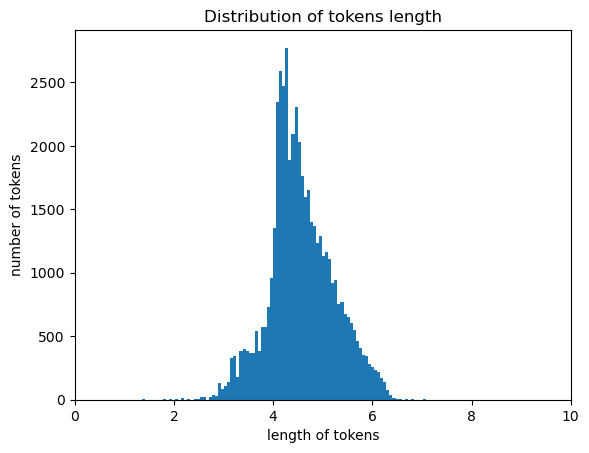

In [72]:
plt.hist(np.log(num_tokens), bins = 100) 
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [73]:
# Take the average of tokens and add the standard deviation of the two tokens,
# the value of max_tokens can cover about 95% of the samples
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
MAX_SEQUENCE_LENGTH = int(max_tokens)
MAX_SEQUENCE_LENGTH

300

In [74]:
# When the length of tokens is 300, about 95% of the samples are covered
# We padding the insufficient length and trimming the super long
np.sum( num_tokens < MAX_SEQUENCE_LENGTH ) / len(num_tokens)

0.9451212133435521

### 5.1.3 Transform texts to tokenized sequences

In [75]:
# For padding and truncating, the input df_train.text is a string
# The returned x_train is a numpy array
# by default the tokens in front of the padding are all 0, and the text is at the end
# after MAX_SEQUENCE_LENGTH (300), tokens will be truncated

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=MAX_SEQUENCE_LENGTH)

print("x_train", x_train.shape)
print("x_test", x_test.shape)

x_train (39665, 300)
x_test (9917, 300)


In [76]:
x_train[0]  # each row is a tokenized sqquence

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

###  5.2 Label Encoding of the Target Variable

In [77]:
labels = df_train.target.unique().tolist()
labels

['negative', 'positive']

In [78]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (39665, 1)
y_test (9917, 1)


## 5.3 glove Emdedding

Now let's prepare the embedding matrix (word vector matrix) for the model. According to the requirements of keras, we need to prepare a matrix with a dimension of num words represents the number of words we use. The embedding dimension is the pre-trained word vector model we are using now is 300, and each word is represented by a vector of length 300.

In this pre-trained glove embedding model, there are a total of 400,000 vocabulary words. If all of them are used in classification problems, it will be a waste of computing resources because our training samples have total of 92,089 words.

In [79]:
GLOVE_EMB = 'Z:/data/glove/glove.6B.300d.txt'
EMBEDDING_DIM = 300  
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = 'Z:/kaggle/Sentiment AnalysisTWT/Output/best_model.hdf5'

In [80]:
embeddings_index = {}  # glove => embedding_index

f = open(GLOVE_EMB,encoding="utf8")
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [81]:
# embedding_matrix is a matrix of [vocab_size, EMBEDDING_DIM]
# The dimension is 92089 * 300

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in embeddings_index.keys():
        embedding_matrix[i] = embeddings_index.get(word)

embedding_matrix.shape       

(92089, 300)

In [82]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

### 6. Build Model

I tried few neural network model, the accuracy score are similar: 

* BiLSTM: Tested LSTM and BiLSTM, and found that BiLSTM performed slightly better than LSTM. Accuracy score of LSTM is 85.5%. BiLSTM'score is 87.4%. After Embedding, in the first layer, we use BiLSTM to return sequences, and then the 16-unit LSTM in the second layer does not return sequences, but only returns the final result. Finally, there is a fully linked layer, which uses the sigmoid activation function to output the result.

* GRU: when GRU is used, the test sample can achieve an accuracy rate of 87.2%, and the  training time is about half of biLSTM.

In [83]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5)) 

# LSTM code
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))  

# BiLSTM Code
# model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
# model.add(LSTM(units=16, return_sequences=False))
# model.add(Dense(1, activation='sigmoid'))     

# GRU code
model.add(GRU(units=32, return_sequences=True))
model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=4, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))    
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          27626700  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 gru_3 (GRU)                 (None, 300, 32)           32064     
                                                                 
 gru_4 (GRU)                 (None, 300, 16)           2400      
                                                                 
 gru_5 (GRU)                 (None, 4)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 27,661,433
Trainable params: 34,733
Non-

### Compile model & Callbacks

In [84]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])

ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

### Train

In [85]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
39/39 [==============================] - 132s 3s/step - loss: 0.6456 - accuracy: 0.6315 - val_loss: 0.5572 - val_accuracy: 0.7270 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 122s 3s/step - loss: 0.5145 - accuracy: 0.7551 - val_loss: 0.4370 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 125s 3s/step - loss: 0.4423 - accuracy: 0.8054 - val_loss: 0.4674 - val_accuracy: 0.8038 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 129s 3s/step - loss: 0.4041 - accuracy: 0.8274 - val_loss: 0.4087 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 5/10
39/39 [==============================] - 131s 3s/step - loss: 0.3826 - accuracy: 0.8373 - val_loss: 0.3976 - val_accuracy: 0.8435 - lr: 0.0010
Epoch 6/10
39/39 [==============================] - 132s 3s/step - loss: 0.3609 - accuracy: 0.8464 - val_loss: 0.3949 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 7/10
39/39 [==============================] - 133s 3s/step - loss: 0.3

### Evaluate

In [86]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 7s 687ms/step - loss: 0.3225 - accuracy: 0.8721

ACCURACY: 0.8721387386322021
LOSS: 0.32248812913894653


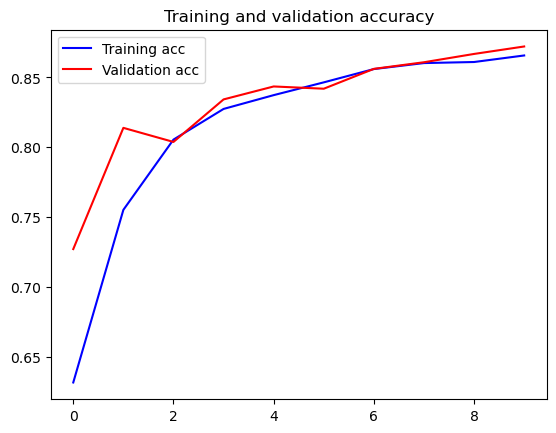

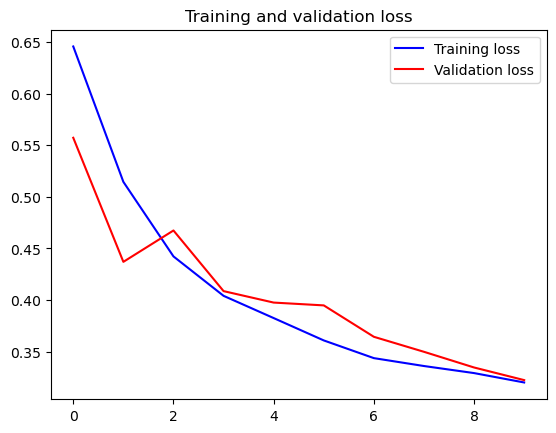

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

We first made predictions on the test samples and got a fairly satisfactory accuracy.
After that, we define a prediction function to predict the polarity of the input text. It can be seen that the model can accurately judge negative sentences and some simple logical structures.

In [88]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = "negative"
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = "positive"

        return label
    else:
        return "negative" if score < 0.5 else "positive"

In [89]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [90]:
# test sample from imdb
# https://www.imdb.com/title/tt0096895/reviews?sort=userRating&dir=asc&ratingFilter=0
predict("A rather cartoony adaptation of the Batman legend")

{'label': 'negative',
 'score': 0.337993323802948,
 'elapsed_time': 0.848888635635376}

### 7. Confusion Matrix

In [91]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 8s 1s/step


In [92]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

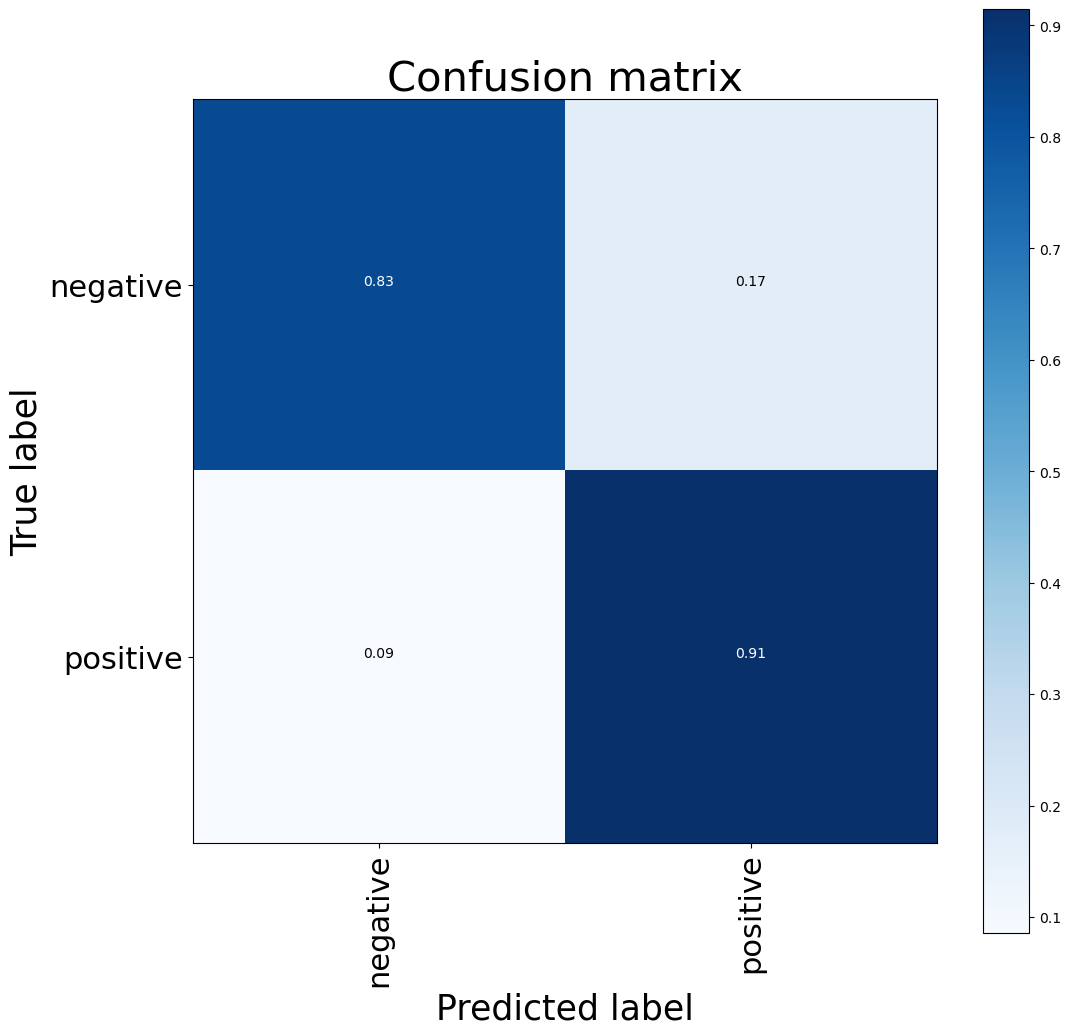

Wall time: 295 ms


In [93]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### 8. Classification Report

In [94]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.91      0.83      0.87      4939
    positive       0.84      0.91      0.88      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



### 9. Accuracy Score

In [95]:
accuracy_score(y_test_1d, y_pred_1d)

0.8721387516386003

### 10. Save model

In [96]:
model.save(KERAS_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

### 11. Reference:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?datasetId=134715
